# Multi-class image classification of surface defects

In [39]:
# Imports
import os
import torch
import tarfile
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models 
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url

### Load data

In [11]:
# Define transforms for training data
transform_train = transforms.Compose([
    transforms.Resize((150,150)), #becasue vgg takes 150*150
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

# Define transforms for validation data
transform_test = transforms.Compose([
    transforms.Resize((150,150)), #becasue vgg takes 150*150
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

In [12]:
# Define data folder paths
train_ds = ImageFolder('../data/train/images/', transform=transform_train)
test_ds = ImageFolder('../data/validation/images/', transform=transform_test)

In [13]:
# Create database loaders
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)

### Exploratory Data Analysis

In [14]:
# Dataset length
len(train_ds),len(test_ds)

(1440, 360)

In [15]:
# Image size
image, label  = train_ds[0]
print(image.shape, label)

torch.Size([3, 150, 150]) 0


TypeError: Invalid shape (3, 150, 150) for image data

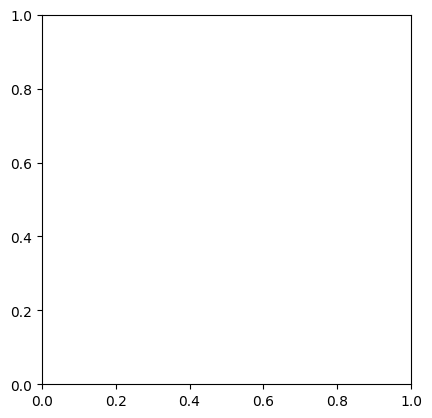

In [17]:
# Plot image
plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 3, 150, 150])


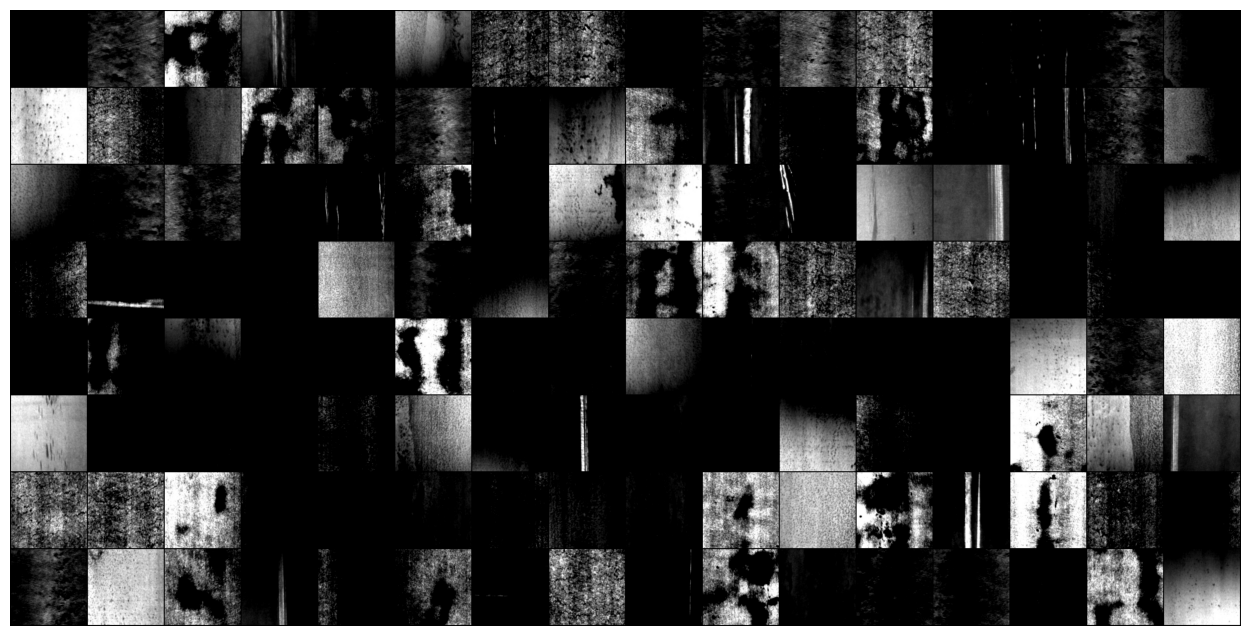

In [15]:
# Create database loader for plotting 
batch_size=128
train_dl2 = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Plot first batch of images
for images, _ in train_dl2:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

### Transfer learning

In [18]:
# Load pretrained model
modelvgg = models.vgg19(pretrained=True)

# Freeze parameters
for p in modelvgg.parameters() : 
    p.requires_grad = False

c:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# Add own layers
modelvgg.classifier = nn.Sequential(
  nn.Linear(in_features=25088, out_features=2048) ,
  nn.ReLU(),
  nn.Linear(in_features=2048, out_features=512) ,
  nn.ReLU(),
  nn.Dropout(p=0.6), 
  nn.Linear(in_features=512 , out_features=6),
  nn.LogSoftmax(dim=1)  
)

### Define classification class

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [22]:
class IntelCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = modelvgg
        
    def forward(self, xb):
        return self.network(xb)

In [23]:
model = IntelCnnModel()

### Mount dataloaders to appropriate device

In [29]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [30]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [31]:
class DeviceDataLoader():
    
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

IntelCnnModel(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

Now define some functions that will be used during training

In [33]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()   #eval() is called to tell model that now it is validation mode and so don't perform stuff like dropout,backpropagation etc..
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        # Training Phase 
        model.train() #eval() is called to tell model that now it is training mode and so  perform stuff like dropout,backpropagation etc..
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [34]:
# Evaluate current model
model = to_device(model, device)
evaluate(model, val_dl)

{'val_loss': 1.7920289039611816, 'val_acc': 0.19230769574642181}

### Train model

In [41]:
# Train params
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.00001

# Train model
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7315, val_loss: 1.6736, val_acc: 0.7228
Epoch [1], train_loss: 1.5874, val_loss: 1.5226, val_acc: 0.7891
Epoch [2], train_loss: 1.3982, val_loss: 1.3380, val_acc: 0.8333
Epoch [3], train_loss: 1.2083, val_loss: 1.1400, val_acc: 0.8698
Epoch [4], train_loss: 1.0113, val_loss: 0.9526, val_acc: 0.9193
Epoch [5], train_loss: 0.8254, val_loss: 0.7915, val_acc: 0.9297
Epoch [6], train_loss: 0.6814, val_loss: 0.6486, val_acc: 0.9479
Epoch [7], train_loss: 0.5597, val_loss: 0.5421, val_acc: 0.9479


In [36]:
# Evaluate model
evaluate(model, val_dl)

{'val_loss': 0.4020068645477295, 'val_acc': 0.9453125}

Function that will plot accuracy graph

In [7]:
# Define accuracy plot function
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')


Function that will plot loss graph

In [38]:
# Define losses plot function
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

### Predict using model

In [40]:
# Make predictions
for i,img in enumerate(test_ds):
    input = img[0]
    label = img[1]
    input = to_device(input, device)
    inputs = input.unsqueeze(0)   # unsqueeze the input i.e. add an additonal dimension
    predictions = model(inputs)
    prediction = predictions[0].detach().cpu()
    print(f"Prediction is {np.argmax(prediction)} of Model whereas given label is {label}")

Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0
Prediction is 5 of Model whereas given label is 0


KeyboardInterrupt: 

In [35]:
# Save model
torch.save(model.state_dict(), 'modelvgg_intel.pth')